<IPython.core.display.Javascript object>


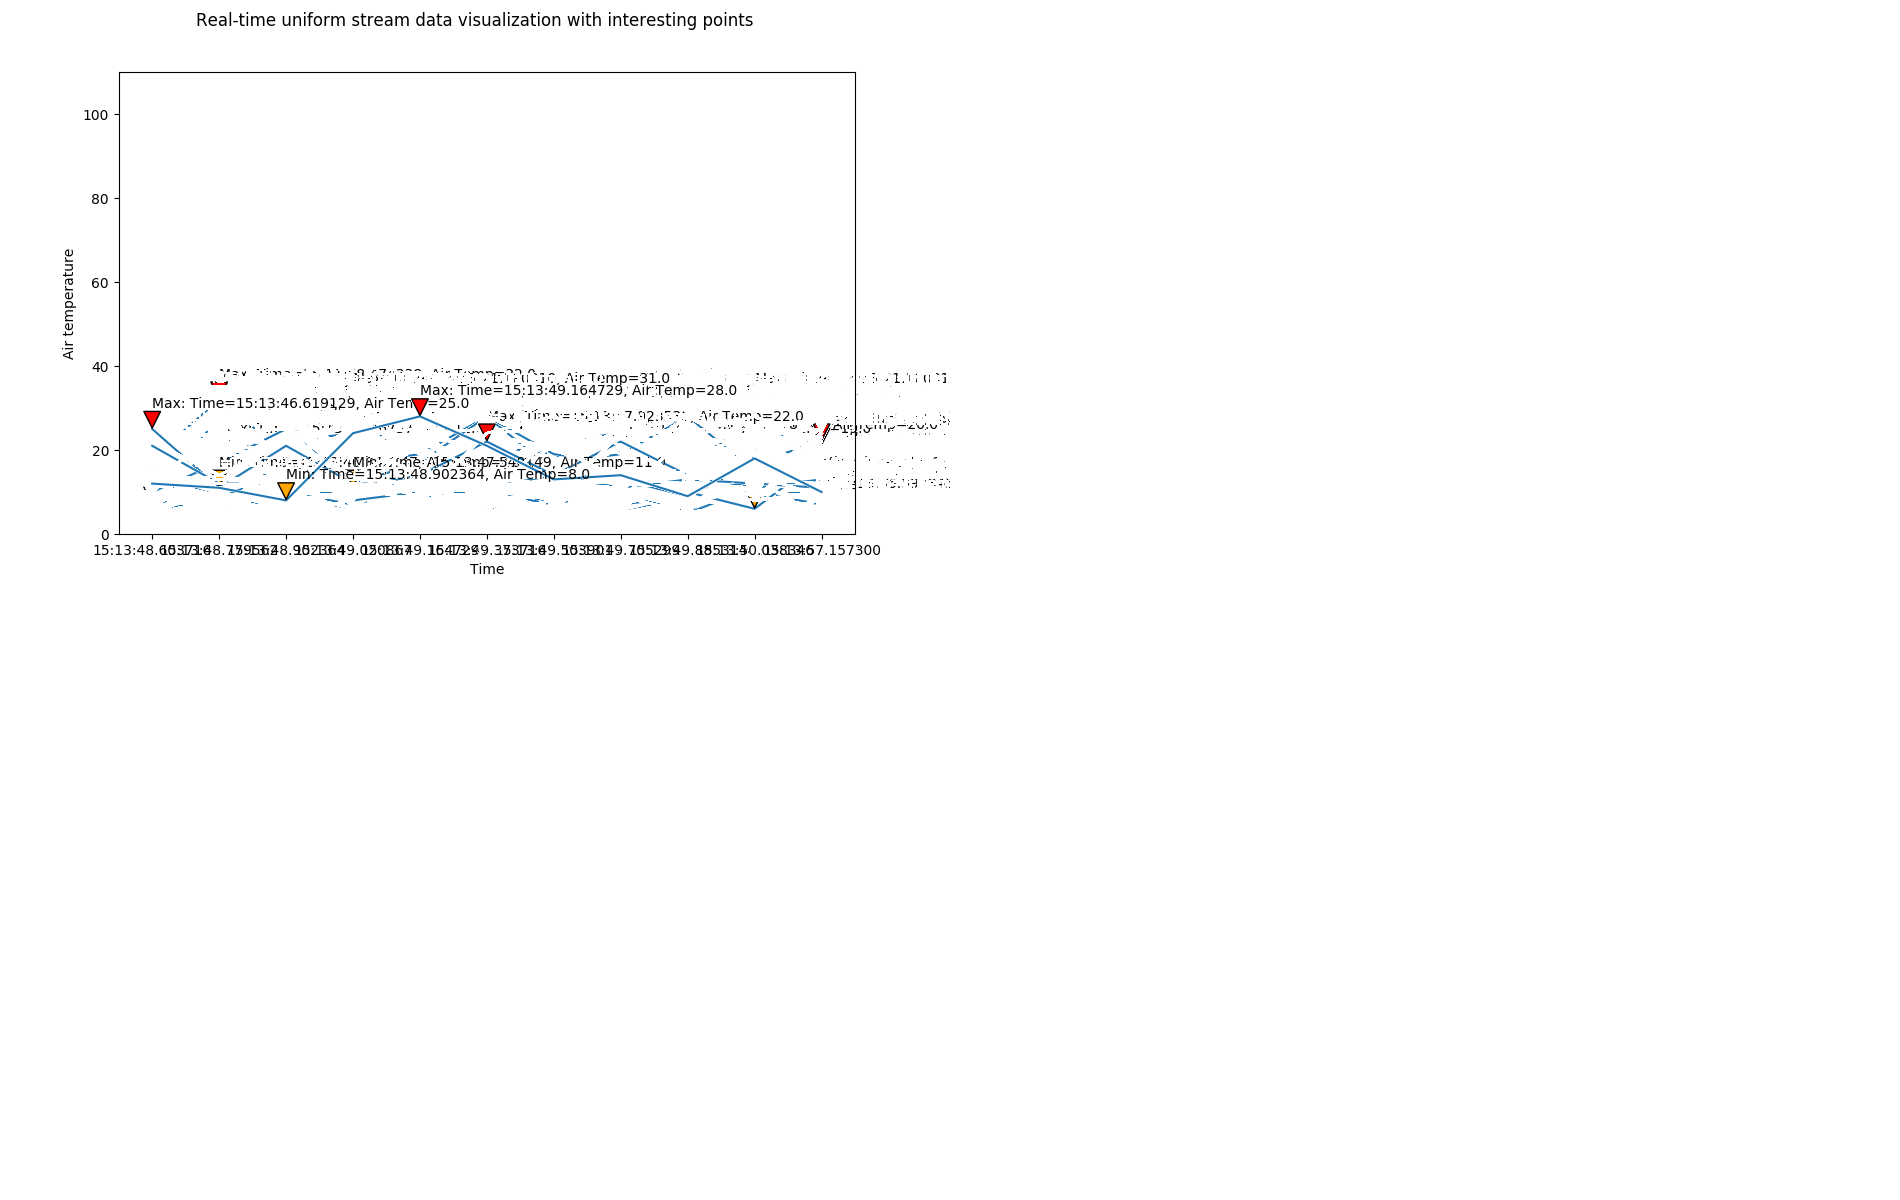

In [3]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta  

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'climate'

#LABEL MAX VALUE ON THE GRAPH

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Air Temp={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

#LABEL MIN VALUE ON THE GRAPH    

def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Air Temp={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

#MAKE CONNECTION TO KAFKA SERVER FOR CONSUMING MESSAGES
    
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

#INITIALIZE PLOT
#SET FIGURE HEIGHT, WIDTH, XLABEL, YLABEL ETC.

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Air Tempearture')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

    

        
# READ MESSAGE FROM KAFKA BROKER
#KEEP A WINDOW SIZE OF ATLEAST 10 TO FIND MAX AND MIN VALUE
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8')).split(',')
            key = str(message.key.decode('utf-8'))
            
            if key != "producer_1":
                continue
                
            air_temp = float(data[2])
            #time = data[7].split('-')[1]
            time = dt.datetime.now().strftime("%H:%M:%S.%f")
            
            x.append(time) 
            y.append(air_temp)
            # print(y)
            # we start plotting only when we have 10 data points'''
            
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air temperature')
                ax.set_ylim(0,110) 
                ax.set_yticks([0,20,40,60,80,100])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

In [ ]:
import pymongo
from pymongo import MongoClient
client = MongoClient()
db = client['fit5148_assignment_db']
climate_collection = db['climate_historic']

In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

cursor = climate_collection.find({})


#FOR EACH DATA FROM MONGO DB
#STRIP THE HOUR PART OF THE DATETIME
#GROUP BY USING HASH TABLE

hotspot_dict ={}
for document in cursor: 
    hotspot_data = document['hotspots']
    for item in hotspot_data:
        dtime = item['datetime']
        first_split = dtime.split('T')
        second_split = first_split[1].split(':')
        hour = second_split[0]
        if(hour in hotspot_dict):
            hotspot_dict[hour] = hotspot_dict[hour] + 1
        else:
             hotspot_dict[hour] = 1


                
#PLOT BAR CHART
#SORT HOUR VALUES FOR PRESENTATION PURPOSE

x = list(hotspot_dict.keys())
print(hotspot_dict)
x.sort(key=int)
y = []
for item in x:
    y.append(hotspot_dict[item]
            )
objects = x
y_pos = np.arange(len(objects))
performance = y

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Fire Count')
plt.xlabel('Hour')
plt.title('Number of Fires per Hour')

plt.show()

#{'03': 298, '00': 163, '12': 42, '23': 16, '01': 27, '04': 1946, '05': 84, '15': 29, '13': 63}

In [ ]:

#CREATE MAP
#SET INITIAL COORDINATES TO VICTORIA STATE

import folium
m = folium.Map(location=[-37.471310, 144.785156])

In [ ]:
#In a map visualize fire locations as markers. Display detailed information such
#as air temperature, surface temperature, relative humidity and confidence
#with the marker tooltip. See the example below. You can use Folium for map
#visualization.
from pprint import pprint

#FOR EACH FIRE DATA, ADD MARKER AND POPOUP TO THE MAP

cursor = climate_collection.find({})

for document in cursor: 
    hotspot_data = document['hotspots']
    air_temp = document['air_temperature_celcius']
    relative_humid = document['relative_humidity']
    
    for item in hotspot_data:
        lat = item['latitude']
        long = item['longitude']
        surface_temp = item['surface_temperature_celcius']
        confidence = item['confidence']
        popup_text = "air temperature," + str(air_temp) + "<br>" + "surface temperature: " + str(surface_temp) + "<br>" + "relative humidity: " + str(relative_humid) + "confidence: " + str(confidence)
        folium.Marker([lat, long],popup = popup_text).add_to(m)
        
m


In [ ]:
1+1